# Create a netCDF file of WSE from a RAS HDF file.
## <u>Purpose:</u>
Having a readily acessbile netcdf of WSE data will allow easy xarray manipulation of data.
#### <u>Use Cases:</u>
    1. Plotting WSE data in a map
    2. Plotting WSE data in a time series for a list of points




In [59]:
hdf_file.close()

In [54]:
import h5py

hdf_file = h5py.File(r"V:\projects\p00659_dec_glo_phase3\01_processing\merge_ras_50_runs\merged\HECRASV6.3.1_BaseModel\East_Galveston_Bay.p50.hdf", 'r')

In [58]:
planName = hdf_file['/Plan Data/Plan Information'].attrs['Plan Name'].decode('utf-8').replace('_', ' ')
planName

'100yr Atlas 14'

In [7]:
# Get the WSE data
wse = hdf_file['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/Model_Domain/Water Surface']
wse.attrs.keys()

<KeysViewHDF5 ['Can Interpolate', 'Can Plot', 'Columns', 'Coverage', 'Location', 'Maximum Value of Data Set', 'Minimum Value of Data Set', 'Name', 'Orientation', 'Rows', 'Units']>

The shape of the WSE data is 2D (time, cell). The cell is related to the geometry of the 2d mesh and can be related to the a coordinate using: /Geometry/2D Flow Areas/2D_Area/Cells Center Coordinate

In [8]:
wse.shape

(1867, 507186)

In [9]:
import numpy as np

wse_data = np.array(wse)
wse_data

array([[ 5.1893532e+01,  5.1875000e+01,  5.1875000e+01, ...,
        -7.1875000e-01, -7.1875000e-01, -7.1875000e-01],
       [ 5.1995068e+01,  5.1895462e+01,  5.1957405e+01, ...,
        -1.7816435e-01, -1.6169344e-01,  1.2676209e-02],
       [ 5.2002239e+01,  5.1909317e+01,  5.1970821e+01, ...,
        -1.7155857e-01, -1.6152963e-01,  5.0397638e-02],
       ...,
       [ 5.1916599e+01,  5.1876411e+01,  5.1968765e+01, ...,
        -4.1829047e-01, -4.1512668e-01, -2.9453334e-01],
       [ 5.1916599e+01,  5.1876408e+01,  5.1968765e+01, ...,
        -4.2085385e-01, -4.1873106e-01, -2.9739940e-01],
       [ 5.1916599e+01,  5.1876408e+01,  5.1968765e+01, ...,
        -4.2337424e-01, -4.2220035e-01, -3.0028129e-01]], dtype=float32)

In [10]:
cell_coords  = hdf_file['/Geometry/2D Flow Areas/Model_Domain/Cells Center Coordinate']
cell_coords_data = np.array(cell_coords)
print (cell_coords.shape, [i.decode('utf-8') for i in cell_coords.attrs['Column']])
print(cell_coords_data)

(507186, 2) ['X', 'Y']
[[ 6645294.3928775  24061908.5867296 ]
 [ 6645094.3928775  24061708.5867296 ]
 [ 6645294.3928775  24061708.5867296 ]
 ...
 [ 6596595.73705168 23822497.28383841]
 [ 6580854.77455409 23821636.31328212]
 [ 6595394.59958824 23959867.5965899 ]]


In [11]:
# Get Projection of the coordinate data
proj = hdf_file.attrs['Projection'].decode('utf-8')

In [12]:
# Get start time
timestamps = [t.decode('utf-8') for t in hdf_file['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp']]
startTime = timestamps[0]

# Get time data referenced as days since start time.
time = np.array(hdf_file['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'])
time

array([-0.00000000e+00,  6.94444444e-03,  1.38888889e-02, ...,
        1.29444444e+01,  1.29513889e+01,  1.29583333e+01])

In [13]:
import pandas as pd

df_columns = ['x', 'y']
df = pd.DataFrame(columns=df_columns)
df['x'] = cell_coords_data[:,0]
df['y'] = cell_coords_data[:,1]
# df['wse'] = wse_data[0,:]
# df['time'] = time
df

,x,y
0,6.645294e+06,2.406191e+07
1,6.645094e+06,2.406171e+07
2,6.645294e+06,2.406171e+07
3,6.645494e+06,2.406171e+07
4,6.644894e+06,2.406151e+07
...,...,...
507181,6.758897e+06,2.393918e+07
507182,6.760531e+06,2.392557e+07
507183,6.596596e+06,2.382250e+07
507184,6.580855e+06,2.382164e+07


In [14]:
cellIds = [item for item in range(0, len(cell_coords_data))]

In [15]:
import xarray as xr
ds = xr.DataArray(wse_data, 
    coords = [time, cellIds],
    #     'cell': (["cell"], cellIds),
    # },
    dims=['time', 'cell']
)
# ds['time'] = time
# ds['cell'] = (cell_coords


In [16]:
# Dataarray to Xarray Dataset
ds = ds.to_dataset(name='wse')
ds

<xarray.Dataset>
Dimensions:  (time: 1867, cell: 507186)
Coordinates:
  * time     (time) float64 -0.0 0.006944 0.01389 0.02083 ... 12.94 12.95 12.96
  * cell     (cell) int32 0 1 2 3 4 5 ... 507181 507182 507183 507184 507185
Data variables:
    wse      (time, cell) float32 51.89 51.88 51.88 ... -0.4234 -0.4222 -0.3003

In [17]:
# ds = ds.assign(x = (['cell','xy'], cell_coords_data))
# cell_coords_data.shape

In [18]:
# ds['cell_coords']

In [19]:
x = np.array(cell_coords_data[:,0])
y = np.array(cell_coords_data[:,1])
ds = ds.assign(x = (['cell'], x))
ds = ds.assign(y = (['cell'], y))

In [20]:
ds

<xarray.Dataset>
Dimensions:  (time: 1867, cell: 507186)
Coordinates:
  * time     (time) float64 -0.0 0.006944 0.01389 0.02083 ... 12.94 12.95 12.96
  * cell     (cell) int32 0 1 2 3 4 5 ... 507181 507182 507183 507184 507185
Data variables:
    wse      (time, cell) float32 51.89 51.88 51.88 ... -0.4234 -0.4222 -0.3003
    x        (cell) float64 6.645e+06 6.645e+06 ... 6.581e+06 6.595e+06
    y        (cell) float64 2.406e+07 2.406e+07 ... 2.382e+07 2.396e+07

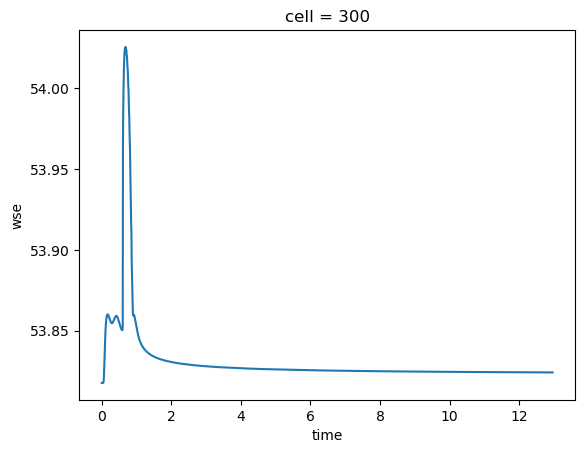

In [21]:
ds.wse[:,300].plot()

In [22]:
# Get WSE data for or QAQC points
import geopandas as gpd
gdf_qaqc = gpd.read_file(r"points.geojson")
gdf_qaqc

,id,geometry
0,6,POINT (-94.55815 29.99732)
1,7,POINT (-94.52477 29.99589)
2,24,POINT (-94.55979 29.96837)
3,25,POINT (-94.52642 29.96694)
4,26,POINT (-94.49305 29.96551)
...,...,...
180,362,POINT (-94.72354 29.42388)
181,363,POINT (-94.69035 29.42249)
182,379,POINT (-94.75829 29.39629)
183,380,POINT (-94.72512 29.39492)


In [23]:
gdf_qaqc.to_crs(proj, inplace=True)
gdf_qaqc

,id,geometry
0,6,POINT (6640034.384 24056928.593)
1,7,POINT (6650594.399 24056928.600)
2,24,POINT (6640034.394 24046368.603)
3,25,POINT (6650594.394 24046368.569)
4,26,POINT (6661154.401 24046368.579)
...,...,...
180,362,POINT (6597794.380 23845728.589)
181,363,POINT (6608354.378 23845728.571)
182,379,POINT (6587234.378 23835168.587)
183,380,POINT (6597794.396 23835168.579)


In [24]:
point_zero = gdf_qaqc.loc[0]
point_zero.geometry.x 

6640034.3840198545

In [25]:
# pull out the hdf geometry to a gdf
x = np.array(cell_coords_data[:,0])
y = np.array(cell_coords_data[:,1])
df = pd.DataFrame()
gdf_hdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x, y), crs=proj)
gdf_hdf.reset_index(inplace=True)
gdf_hdf.rename(columns={'index':'cell'}, inplace=True)
gdf_hdf.tail()

,cell,geometry
507181,507181,POINT (6758897.278 23939183.712)
507182,507182,POINT (6760530.727 23925574.619)
507183,507183,POINT (6596595.737 23822497.284)
507184,507184,POINT (6580854.775 23821636.313)
507185,507185,POINT (6595394.600 23959867.597)


<Axes: >

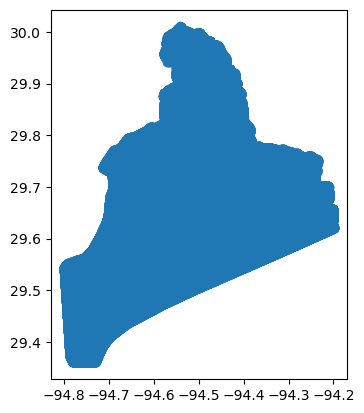

In [26]:
gdf_hdf.to_crs(4326, inplace=True)
gdf_hdf.plot()

<Axes: >

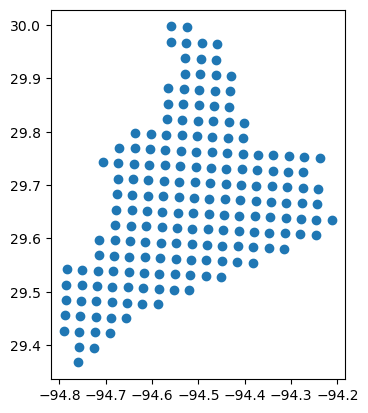

In [27]:
gdf_qaqc.to_crs(4326, inplace=True)
gdf_qaqc.plot()

In [28]:
# Get nearest cell to the QAQC points
from scipy.spatial import cKDTree

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

gdf_nearest = ckdnearest(gdf_qaqc, gdf_hdf)


In [29]:
gdf_nearest

,id,geometry,cell,dist
0,6,POINT (-94.55815 29.99732),576,0.000197
1,7,POINT (-94.52477 29.99589),628,0.000320
2,24,POINT (-94.55979 29.96837),7973,0.000250
3,25,POINT (-94.52642 29.96694),8021,0.000355
4,26,POINT (-94.49305 29.96551),8070,0.000253
...,...,...,...,...
180,362,POINT (-94.72354 29.42388),383666,0.000319
181,363,POINT (-94.69035 29.42249),383714,0.000197
182,379,POINT (-94.75829 29.39629),387106,0.000249
183,380,POINT (-94.72512 29.39492),387151,0.000353


In [36]:
# For each QAQC point, cell value to lookup cellID froom the Xarray dataset to get the WSE timeseries
gdf_nearest['wse_ts'] = None
for i, row in gdf_nearest.iterrows():
    cell = row['cell']
    gdf_nearest.at[i,'wse_ts'] = wse_data[:,cell]

gdf_nearest

,id,geometry,cell,dist,wse_ts
0,6,POINT (-94.55815 29.99732),576,0.000197,"[52.34477, 52.34477, 52.34477, 52.34477, 52.34..."
1,7,POINT (-94.52477 29.99589),628,0.000320,"[52.5, 52.5, 52.5, 52.5, 52.5, 52.5, 52.5, 52...."
2,24,POINT (-94.55979 29.96837),7973,0.000250,"[45.9375, 45.9375, 45.9375, 45.9375, 45.9375, ..."
3,25,POINT (-94.52642 29.96694),8021,0.000355,"[42.125, 42.154007, 42.20755, 42.23036, 42.252..."
4,26,POINT (-94.49305 29.96551),8070,0.000253,"[39.375, 39.375, 39.375, 39.375, 39.375, 39.37..."
...,...,...,...,...,...
180,362,POINT (-94.72354 29.42388),383666,0.000319,"[-0.71875, -0.7142108, -0.6688573, -0.34346417..."
181,363,POINT (-94.69035 29.42249),383714,0.000197,"[5.84375, 6.0255456, 6.05046, 6.0595865, 6.071..."
182,379,POINT (-94.75829 29.39629),387106,0.000249,"[-0.71875, -0.5671853, -0.24970222, -0.2297003..."
183,380,POINT (-94.72512 29.39492),387151,0.000353,"[1.449538, 1.7018915, 1.7789713, 1.8048677, 1...."


In [62]:
import plotly.graph_objects as go
# set up plotly figure
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=timestamps,
    y=gdf_nearest['wse_ts'][0],
    hovertext=gdf_nearest['id'],
    hoverinfo="text",
    # marker=dict(
    #     color="blue"
    # ),
    showlegend=True,
    name="QAQC Point 1"
))


fig.show()

In [46]:
df = pd.DataFrame(columns=['wse', 'datetime'])
df['wse'] = gdf_nearest['wse_ts'][0]
df['datetime'] = timestamps
df

,wse,datetime
0,52.344769,01JAN1970 01:00:00
1,52.344769,01JAN1970 01:10:00
2,52.344769,01JAN1970 01:20:00
3,52.344769,01JAN1970 01:30:00
4,52.344769,01JAN1970 01:40:00
...,...,...
1862,52.363094,13JAN1970 23:20:00
1863,52.363087,13JAN1970 23:30:00
1864,52.363083,13JAN1970 23:40:00
1865,52.363075,13JAN1970 23:50:00


In [53]:
import plotly.express as px
    
fig = px.line(df, x="datetime", y='wse', title='pointID')
fig.add_scatter(x=timestamps, y=gdf_nearest['wse_ts'][0], mode='lines', hovertext=df['wse'] , hoverinfo="text", name=f"pointID: {gdf_nearest['id'][0]}")
fig.add_scatter(x=timestamps, y=gdf_nearest['wse_ts'][1], mode='lines', hovertext=df['wse'] , hoverinfo="text", name=f"pointID: {gdf_nearest['id'][1]}")
fig.show()